In [1]:
import sys
import os
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath('../..'))

from offshore_wind_nj.config import JERSEY_ATLANTIC_DATA_DIR, FIGURES_DIR
import matplotlib.pyplot as plt
from pyproj import Proj, Transformer

2025-03-28 12:02:07.047 | INFO     | offshore_wind_nj.config:<module>:11 - PROJ_ROOT path is: /nfs/storage1/home/noriegac/Documents/Offshore_Wind_Research


# **Data Description:**

## **Data Overview:**
The dataset consist of **5 turbines** located at the [**Jersey-Atlantic Wind Farm**](https://www.acua.com/Projects/Jersey-Atlantic-Wind-Farm.aspx), in Atlantic City, New Jersey. The was data shared by Brandon from [Leeward Renewable Energy, LLC](https://www.lreus.com/). The time period is from **March, 1st to December, 31st 2022**, with observations recorded every **10 minutes** for each turbine. The dataset includes time-stamped records of **wind speed**, **wind direction**, and **power output** (energy produced by each turbine), along with turbine identification information. Additionally, the data is used to analyze the **correlation** between wind conditions (speed and direction) and the corresponding energy output for each turbine.

## **Columns:**
1. **Turbine**: The identifier for each of the 5 turbines (T01, T02, T03, T04, T05) in the wind farm. The dataset contains data for each turbine separately, allowing for analysis of individual turbine performance.
2. **WindSpeed**: Wind speed measured in meters per second (m/s), recorded at 10 min regular intervals. This feature help to assess the potential energy generation capacity of each turbine under varying wind conditions.
3. **PowerkW**: The energy output from each turbine, measured in kilowatts (kW). This is a key performance indicator that reflects the efficiency of each turbine in converting wind energy into electrical power.
4. **WindDirection**: The direction from which the wind is blowing, measured in degrees (0° to 360°). Wind direction data help understanding how the positioning of turbines affects their energy generation efficiency. and for modeling wind farm layout optimization.
5. **Timestamp**: Time of measurement, recorded every 10 minutes from March to December 2022. This time series data allows for the analysis of trends, patterns, and seasonal variations in wind conditions and turbine performance.

## **Data Analysis Focus:**
1. **Resampling**: The data is resampled to different time periods (e.g., hourly, daily, weekly, monthly) to understand how wind conditions and power output change over time and to assess turbine performance under different wind patterns.
   
2. **Correlation Analysis**: There is a focus on examining the relationship between wind speed and power output, with a strong correlation observed (e.g., 0.97). This indicates that as wind speed increases, the energy output tends to rise as well, which is typical for wind turbines.

3. **Wind Roses**: Wind roses are used to visualize the distribution of wind speed and direction across different turbines. This helps in understanding the prevailing wind patterns and their impact on turbine performance.

4. **Turbine-to-Turbine Correlation**: The analysis includes investigating how similar the performance of different turbines is, with correlations around **0.9** suggesting that turbines in the same wind farm are generally experiencing similar conditions and producing similar energy outputs.

5. **Visualization**: Various plots, including line plots for time-based analysis, heatmaps for correlation analysis, and wind rose plots for spatial wind pattern analysis, are used to explore the data and interpret turbine performance under varying conditions.

---
## **Research question**
- What **atmospheric conditions** and turbine-specific factors (e.g., wake effects, yaw misalignment, or local turbulence) explain the differences in wind rose patterns across turbines, despite their strong correlation in wind speed and power output?

# Load Jersey Atlantic Wind Farm Data
## File path

In [2]:
jersy_atlantic_path = JERSEY_ATLANTIC_DATA_DIR / 'JAW_Wind_Data.xlsx'

## Loading Dataset

In [3]:
df = pd.read_excel(jersy_atlantic_path)

In [4]:
df.head(10)

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW
0,T01,2022-03-01 00:00:00,4.5,219.0,187.0
1,T02,2022-03-01 00:00:00,4.9,151.0,282.0
2,T03,2022-03-01 00:00:00,6.0,276.0,319.0
3,T04,2022-03-01 00:00:00,4.1,166.0,171.0
4,T05,2022-03-01 00:00:00,4.8,171.0,-10.0
5,T01,2022-03-01 00:10:00,4.2,216.0,149.0
6,T02,2022-03-01 00:10:00,5.2,154.0,332.0
7,T03,2022-03-01 00:10:00,5.8,278.0,284.0
8,T04,2022-03-01 00:10:00,4.0,162.0,163.0
9,T05,2022-03-01 00:10:00,5.0,166.0,-10.0


In [5]:
# Check timestamps with missing data
# missing_timestamps = df[df.isna().any(axis=1)]['StampTime'].unique()
# missing_timestamps

## Extract Minute, Hour & day of the year -> create cyclic encodings

In [6]:
# df['date'] = df['StampTime'].dt.date
# df['time'] = df['StampTime'].dt.time

# Extract time-based features
df["Minute"] = df["StampTime"].dt.minute
df["Hour"] = df["StampTime"].dt.hour
df["DayOfYear"] = df["StampTime"].dt.dayofyear

# Cyclic encoding for time features
df["Minute_sin"] = np.sin(2 * np.pi * df["Minute"] / 60)
df["Minute_cos"] = np.cos(2 * np.pi * df["Minute"] / 60)
df["Hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
df["Hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)
df["Day_sin"] = np.sin(2 * np.pi * df["DayOfYear"] / 365)
df["Day_cos"] = np.cos(2 * np.pi * df["DayOfYear"] / 365)

In [7]:
# Keep only transformed time variables for PCA
time_features = ["Day_sin","Day_cos","Hour_sin", "Hour_cos", "Minute_sin", "Minute_cos"]

In [8]:
df[time_features]

,Day_sin,Day_cos,Hour_sin,Hour_cos,Minute_sin,Minute_cos
0,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
1,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
2,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
3,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
4,8.587640e-01,0.512371,0.000000,1.000000,0.000000,1.0
...,...,...,...,...,...,...
220310,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5
220311,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5
220312,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5
220313,6.432491e-16,1.000000,-0.258819,0.965926,-0.866025,0.5


# Data preprocessing: u & v vectors exploration

In [9]:
df['u_vector'] = np.sin(np.radians(df['WindDirection'])) * df['WindSpeed']
df['v_vector'] = np.cos(np.radians(df['WindDirection'])) * df['WindSpeed']

## Fill NaN for PowerKw as -10

In [10]:
df.fillna({'PowerkW':-10}, inplace=True)

## Drop StampTimes where there is completely missing data

In [11]:
# Identify timestamps where ALL turbines have missing WindSpeed data
timestamps_all_missing = df.groupby('StampTime')['WindSpeed'].apply(lambda x: x.isna().all())

# Get a list of these timestamps
timestamps_to_drop = timestamps_all_missing[timestamps_all_missing].index

# Drop rows with these timestamps
df = df[~df['StampTime'].isin(timestamps_to_drop)].reset_index(drop=True)


In [12]:
df[df['StampTime'].isin(timestamps_all_missing[timestamps_all_missing].index)]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector


## Fill missing wind speed and wind vectors by calculating the mean if there is data at a given time

In [13]:
for column in ['WindSpeed', 'u_vector', 'v_vector']:
    df[column] = df.groupby('StampTime')[column]\
                                    .transform(lambda x: x.fillna(x.mean()))

## Re-calculate the Wind Direction

In [14]:
# Compute wind direction from u and v components
def compute_wind_direction(u, v):
    wind_direction = (np.degrees(np.arctan2(u, v)) + 360) % 360
    return wind_direction

# Example usage:
df['WindDirection'] = compute_wind_direction(df['u_vector'], df['v_vector'])

In [15]:
df[df.isna().any(axis=1)]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector


## Create new features that capture the non-linear relationship between power output & Wind Speed

In [16]:
df["WindSpeed_Squared"] = df["WindSpeed"] ** 2
df["WindSpeed_Cubic"] = df["WindSpeed"] ** 3

/tmp/ipykernel_40321/3481697725.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df["WindSpeed_Cubic"], df["PowerkW"], alpha=0.6, cmap="viridis")


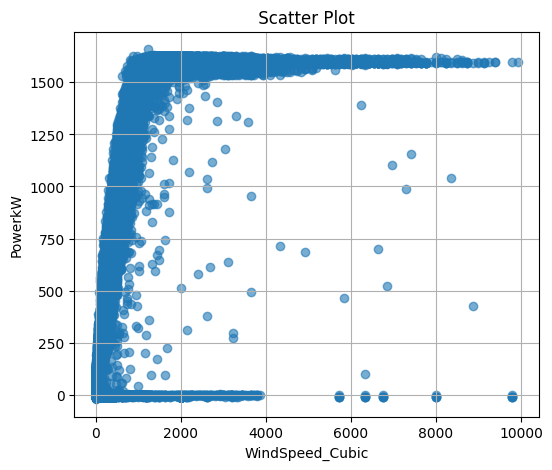

In [17]:
# Visualize the first two PCA components
plt.figure(figsize=(6, 5))
plt.scatter(df["WindSpeed_Cubic"], df["PowerkW"], alpha=0.6, cmap="viridis")
plt.xlabel("WindSpeed_Cubic")
plt.ylabel("PowerkW")
plt.title(" Scatter Plot ")
plt.grid(True)
plt.show()

# Unsupervised ML
## PCA
🔹 **What is Variance?**
Variance measures how much a set of data points deviate from their mean. In PCA, variance is used to **determine how much information each principal component retains from the original dataset.** The explained variance quantifies the proportion of total variability preserved in each component, helping to represent the data while minimizing redundancy.

🔹 **What is PCA?**
Principal Component Analysis (PCA) is a dimensionality reduction technique that **identifies the dominant patterns of variation in a dataset**. It finds the directions (axes) in multi-dimensional space where **variance is maximized**, allowing for a simplified yet meaningful representation of the dataset.

Instead of analyzing individual variables separately, **PCA captures how features vary in relation to one another, making it particularly useful when variables are highly correlated** (e.g., wind speed and power generation). By transforming the dataset into a new coordinate system, PCA reorients the axes

**03/17/2025**: Dr. Robila's feedback
- **Review Independent Component Analysis**
- **Find ground truth values (check wheather station)**
- Need to show clear separation of the work (Not sure what it means...)
- Check the wind patterns specifially in the leasing areas: From Sentinel K-means, check how the clusters describe the wind leases areas for NJ

**03/20/2025**: Dr. Varde's feedback
- I proposed **GNN**, but Dr. Aparna that I need to find a **justification for why** I selected this technique
- Need to have at least one explainable classifier; try **SVM for binary data & high-dimensional**, this method add explainability of the data
### df_times 
**['WindSpeed', 'PowerkW', Day_sin', 'Day_cos', 'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos']**

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select numerical columns for PCA (exclude timestamp)
wind_speed_time_features = df[['WindSpeed', 'PowerkW', 'WindSpeed_Squared', 'WindSpeed_Cubic'] + time_features]  # Adjust if necessary

# Standardize the features before PCA
scaler = StandardScaler()
wind_speed_time_features_scaled = scaler.fit_transform(wind_speed_time_features)

# Apply PCA
pca_wind_speed_time = PCA()
pca_transformed_wind_speed_time = pca_wind_speed_time.fit_transform(wind_speed_time_features_scaled)

#### Explained variance plot to determine the number of components to keep

The explained variance ratio represents **the proportion of total variance captured by each principal component (PC)**. This means each PC quantifies how much of the dataset’s variability it retains.

- For example:
    - PCA_1 explains **36.76%** of the total variance.
    - PCA_2 explains **11.72%** of the total variance.
    - Together, PCA_1 and PCA_2 explain **48.48%** of the dataset’s variability.
    
Having two principal components (PCs) that together explain only 39.16% of the variance indicates that more components are needed to adequately describe the dataset. This suggests that the dataset has a complex structure, where variance is spread across multiple features rather than being concentrated in just one or two dominant patterns.

In [19]:
# pca_wind_speed_time.explained_variance_ratio_

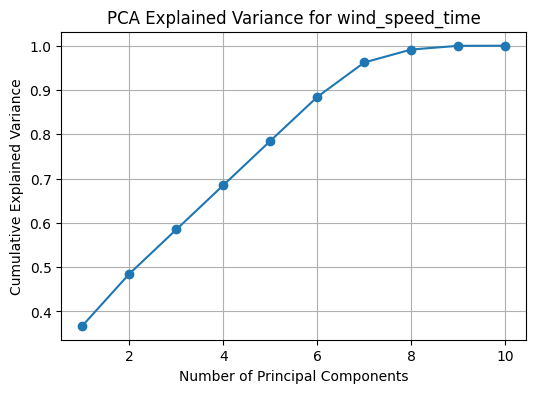

In [20]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca_wind_speed_time.explained_variance_ratio_) + 1), np.cumsum(pca_wind_speed_time.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance for wind_speed_time")
plt.grid(True)
plt.show()



In [21]:
# Determine optimal number of components (e.g., keep enough to explain ~95% variance)
n_components_wind_speed_time = np.argmax(np.cumsum(pca_wind_speed_time.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of PCA components: {n_components_wind_speed_time}")

Optimal number of PCA components: 7


#### Apply PCA with optimal components
- The PCA Explained Variance for wind_speed_time plot indicates that the optimal number of principal components is 7. This selection is based on the 95% variance threshold, meaning that these 7 components together explain at least 95% of the total variability in the dataset.

- By choosing 7 PCA components, we retain the most significant patterns in the data while reducing dimensionality and filtering out noise and redundancy. This ensures that the transformed dataset preserves essential information while eliminating less important variations.



In [22]:
# n_components_wind_speed_time=10

In [23]:
pca_components_wind_speed_time = PCA(n_components=n_components_wind_speed_time)
pca_wind_speed_time_features = pca_components_wind_speed_time.fit_transform(wind_speed_time_features)

#### Convert PCA results to DataFrame

In [24]:
pca_columns_wst = [f"PCA_{i+1}" for i in range(n_components_wind_speed_time)]
df_pca_wst = pd.DataFrame(pca_wind_speed_time_features, columns=pca_columns_wst)
# df_pca_wst["StampTime"] = df["StampTime"].values  # Retain timestamp for reference

#### 2D Scatter Plot for PCA 1 vs PCA 2

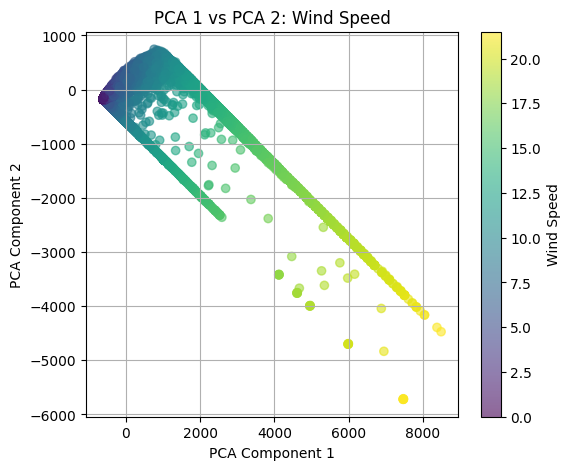

In [25]:
# Visualize the first two PCA components
plt.figure(figsize=(6, 5))
plt.scatter(df_pca_wst["PCA_1"], df_pca_wst["PCA_2"], alpha=0.6,  c=df["WindSpeed"], cmap="viridis")
plt.colorbar(label='Wind Speed')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA 1 vs PCA 2: Wind Speed")
plt.grid(True)
plt.show()

- **The PCA Scatter plot (Wind speed)** shows that when the wind speeds reaches the max speed that a turbine can handle, then the PCA Analysis is showing that the power output does not increment. Likewise, there are instances where there is a high wind speed but there are unexpected energy output. **Thesis**: when there is a high wind speed, there should be more distortion downstream that could cause that some turbines do not extract energy

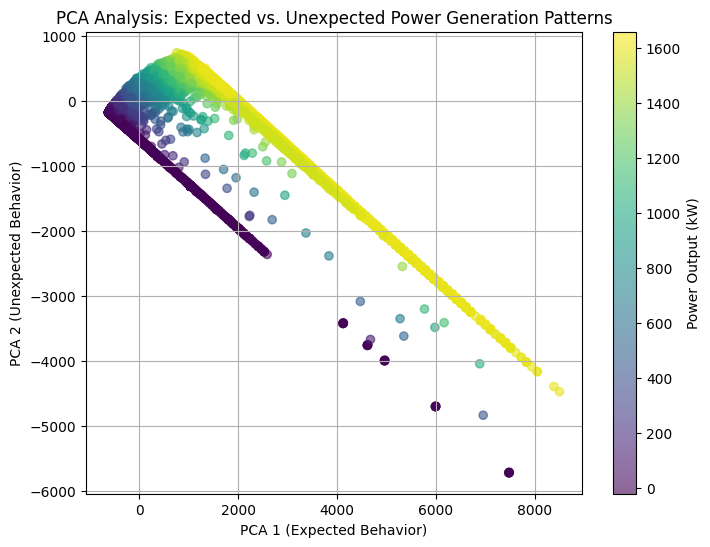

In [26]:
import matplotlib.pyplot as plt

# Plot PCA_1 vs. PCA_2
plt.figure(figsize=(8, 6))
plt.scatter(pca_wind_speed_time_features[:, 0], pca_wind_speed_time_features[:, 1], c=df["PowerkW"], cmap="viridis", alpha=0.6)
plt.colorbar(label='Power Output (kW)')
plt.xlabel('PCA 1 (Expected Behavior)')
plt.ylabel('PCA 2 (Unexpected Behavior)')
plt.title('PCA Analysis: Expected vs. Unexpected Power Generation Patterns')
plt.grid(True)
plt.show()


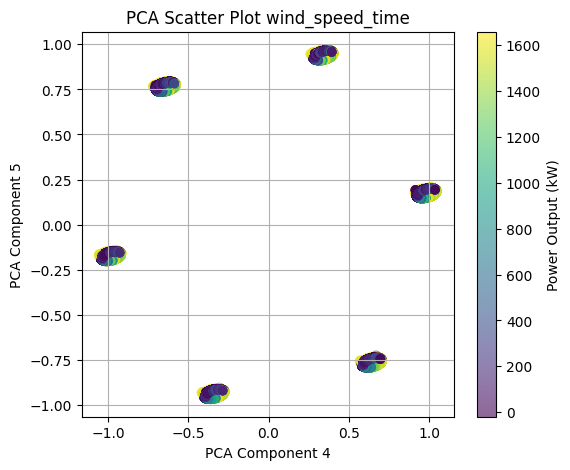

In [27]:
# Visualize the first two PCA components
plt.figure(figsize=(6, 5))
plt.scatter(df_pca_wst["PCA_6"], df_pca_wst["PCA_5"],c=df["PowerkW"], alpha=0.6, cmap="viridis")
plt.colorbar(label='Power Output (kW)')
plt.xlabel("PCA Component 4")
plt.ylabel("PCA Component 5")
plt.title("PCA Scatter Plot wind_speed_time")
plt.grid(True)
plt.show()

**Plot PCA Vectors (Eigenvectors) for PCA_1 and PCA_2**

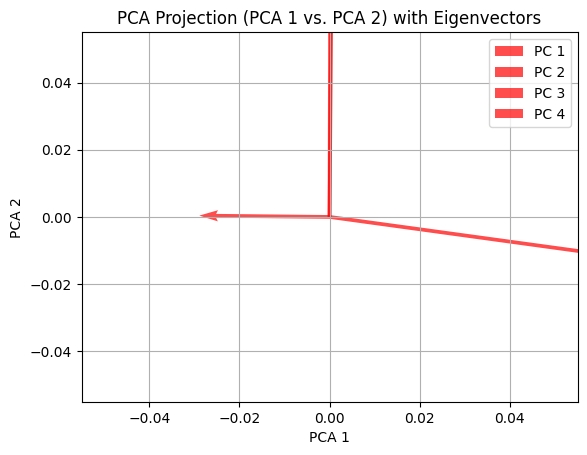

In [28]:
origin = np.zeros((2,))  # Origin for vectors
for i, comp in enumerate(pca_components_wind_speed_time.components_[:4]):  # Only taking PCA 1 & 2
    plt.quiver(*origin, comp[0], comp[1], angles='xy', scale_units='xy', scale=0.5, color='r', alpha=0.7, label=f"PC {i+1}")

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA Projection (PCA 1 vs. PCA 2) with Eigenvectors")
plt.legend()
plt.grid(True)
plt.show()

#### 3D Scatter Plot for PCA 1 vs. PCA 2 vs. PCA 3

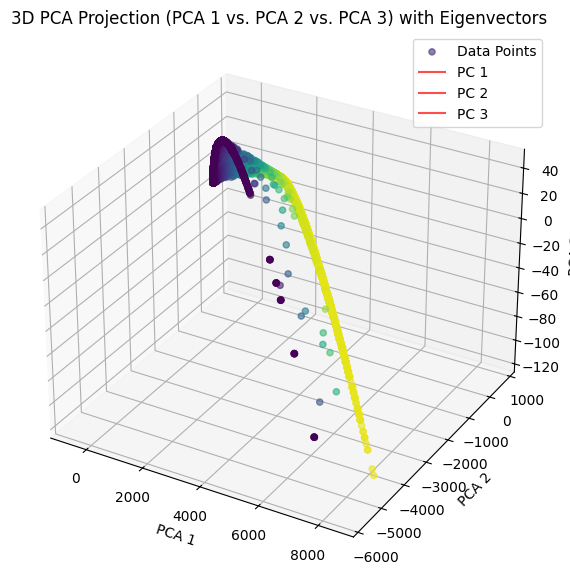

In [29]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_wind_speed_time_features[:, 0], pca_wind_speed_time_features[:, 1], pca_wind_speed_time_features[:, 2], alpha=0.6, label="Data Points", c=df["PowerkW"])

# Plot PCA Vectors (Eigenvectors) for PCA_1, PCA_2, PCA_3
origin = np.zeros((3,))  # Origin for vectors
for i, comp in enumerate(pca_components_wind_speed_time.components_[:3]):  # Taking only first 3 components
    ax.quiver(*origin, *comp[:3], color='r', alpha=0.7, length=0.5, label=f"PC {i+1}")

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection (PCA 1 vs. PCA 2 vs. PCA 3) with Eigenvectors")
ax.legend()
plt.show()


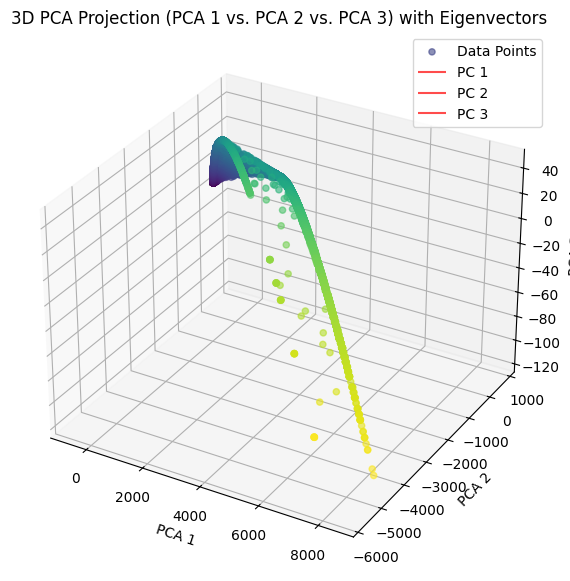

In [30]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_wind_speed_time_features[:, 0], pca_wind_speed_time_features[:, 1], pca_wind_speed_time_features[:, 2], alpha=0.6, label="Data Points", c=df["WindSpeed"])

# Plot PCA Vectors (Eigenvectors) for PCA_1, PCA_2, PCA_3
origin = np.zeros((3,))  # Origin for vectors
for i, comp in enumerate(pca_components_wind_speed_time.components_[:3]):  # Taking only first 3 components
    ax.quiver(*origin, *comp[:3], color='r', alpha=0.7, length=0.5, label=f"PC {i+1}")

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection (PCA 1 vs. PCA 2 vs. PCA 3) with Eigenvectors")
ax.legend()
plt.show()


- There are **two** phenomenon in the dataset: when the wind speed is at certain speed, it either finds the maximun energy output from the turbines or does not produce energy at all.

#### Visualize PCA Component Contribution Heatmap

In [31]:
wind_speed_time_features.columns

Index(['WindSpeed', 'PowerkW', 'WindSpeed_Squared', 'WindSpeed_Cubic',
       'Day_sin', 'Day_cos', 'Hour_sin', 'Hour_cos', 'Minute_sin',
       'Minute_cos'],
      dtype='object')

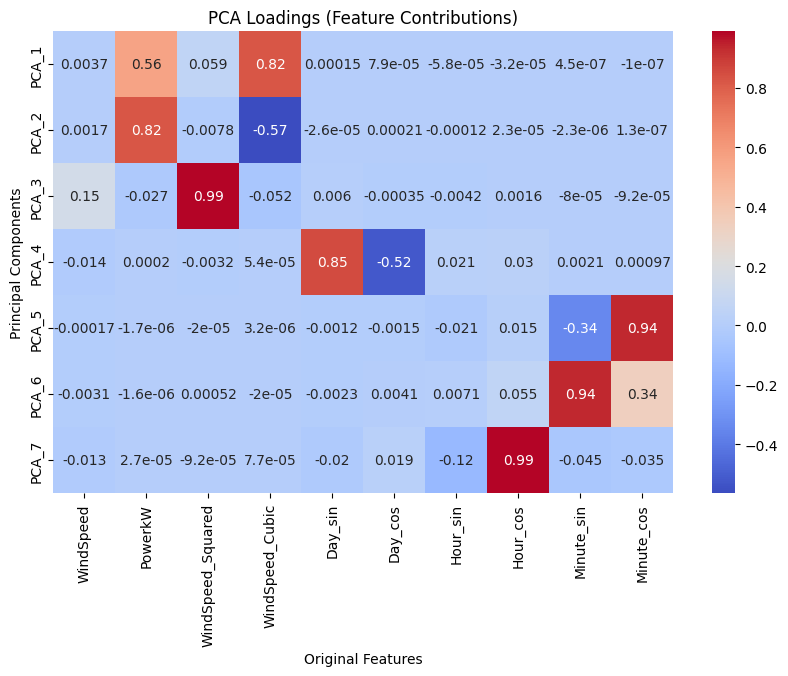

In [32]:
plt.figure(figsize=(10, 6))
sns.heatmap(pca_components_wind_speed_time.components_, cmap="coolwarm", annot=True, xticklabels=wind_speed_time_features.columns, yticklabels=pca_columns_wst)
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.title("PCA Loadings (Feature Contributions)")
plt.show()

- **PCA 1** captures the relationship between the **cubic wind speed** and the power output, which is expected for the power curve relationship
- On the other hand, **PCA 2** is capturing that when the cubic wind speed increases, the PCA 2 will decrease. This relate to unexpected behaviors when wind speed is high but the output energy is low or none.

#### Comparing PCA with the orinal dataset

In [33]:
df_combined  = pd.concat([df.reset_index(drop=True), df_pca_wst], axis=1)

In [34]:
pd.set_option('display.max_columns',30)

df_combined.head()

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed_Squared,WindSpeed_Cubic,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,T01,2022-03-01,4.5,219.0,187.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,-2.831942,-3.497157,20.25,91.125,-432.827755,-64.590126,0.079951,0.507198,0.952728,0.393720,0.935129
1,T02,2022-03-01,4.9,151.0,282.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,2.375567,-4.285637,24.01,117.649,-357.128643,-1.246353,-0.089648,0.509515,0.952504,0.393770,0.934308
2,T03,2022-03-01,6.0,276.0,319.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,-5.967131,0.627171,36.00,216.000,-254.563943,-26.408691,5.759848,0.467720,0.952323,0.394611,0.927796
3,T04,2022-03-01,4.1,166.0,171.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,0.991880,-3.978212,16.81,68.921,-460.344277,-65.211678,-1.781479,0.519669,0.952823,0.393627,0.938394
4,T05,2022-03-01,4.8,171.0,-10.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,0.750885,-4.740904,23.04,110.592,-527.873581,-238.118778,7.145650,0.456097,0.953022,0.394168,0.927220


##### Define deviation threshold (e.g., top 10% of PCA_2 values)

In [35]:
threshold = df_combined["PCA_2"].quantile(0.10)

# Filter rows with high deviation (unexpected behavior)
df_deviations = df_combined[df_combined["PCA_2"] < threshold]

In [36]:
df_deviations

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed_Squared,WindSpeed_Cubic,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
4,T05,2022-03-01 00:00:00,4.8,171.0,-10.0,0,0,60,0.000000e+00,1.0,0.000000,1.000000e+00,0.858764,0.512371,0.750885,-4.740904,23.04,110.592,-527.873581,-238.118778,7.145650,0.456097,0.953022,0.394168,0.927220
9,T05,2022-03-01 00:10:00,5.0,166.0,-10.0,10,0,60,8.660254e-01,0.5,0.000000,1.000000e+00,0.858764,0.512371,1.209609,-4.851479,25.00,125.000,-515.896841,-246.277688,8.354687,0.449009,0.187705,1.037192,0.904334
14,T05,2022-03-01 00:20:00,5.2,277.0,64.0,20,0,60,8.660254e-01,-0.5,0.000000,1.000000e+00,0.858764,0.512371,-5.161240,0.633721,27.04,140.608,-461.143332,-194.073431,7.593647,0.454037,-0.752097,0.697108,0.939813
407,T03,2022-03-01 13:30:00,2.8,316.0,0.0,30,13,60,5.665539e-16,-1.0,-0.258819,-9.659258e-01,0.858764,0.512371,-1.945043,2.014151,7.84,21.952,-596.096254,-179.651782,-3.777762,0.464847,-0.950501,-0.396376,-0.897330
412,T03,2022-03-01 13:40:00,2.8,334.0,-8.0,40,13,60,-8.660254e-01,-0.5,-0.258819,-9.659258e-01,0.858764,0.512371,-1.227439,2.516623,7.84,21.952,-600.613465,-186.250922,-3.563008,0.461950,-0.185197,-1.039269,-0.876275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214177,T03,2022-12-28 18:20:00,2.8,165.0,-4.0,20,18,362,8.660254e-01,-0.5,-1.000000,-1.836970e-16,-0.051620,0.998667,0.724693,-2.704592,7.84,21.952,-598.354947,-182.951121,-3.671533,-0.550252,-0.745794,0.638793,0.121701
214182,T03,2022-12-28 18:30:00,3.2,161.0,4.0,30,18,362,5.665539e-16,-1.0,-1.000000,-1.836970e-16,-0.051620,0.998667,1.041818,-3.025659,10.24,32.768,-584.791600,-182.483688,-2.025007,-0.563863,-0.920248,-0.344427,0.173708
214187,T03,2022-12-28 18:40:00,3.5,160.0,11.0,40,18,362,-8.660254e-01,-0.5,-1.000000,-1.836970e-16,-0.051620,0.998667,1.197071,-3.288924,12.25,42.875,-572.399778,-182.437505,-0.714271,-0.574043,-0.155031,-0.987422,0.191940
214192,T03,2022-12-28 18:50:00,3.4,162.0,14.0,50,18,362,-8.660254e-01,0.5,-1.000000,-1.836970e-16,-0.051620,0.998667,1.050658,-3.233592,11.56,39.304,-573.686378,-177.939136,-1.303577,-0.569014,0.784632,-0.647303,0.158079


In [37]:
df_combined["PCA_2"].describe()

count    2.165050e+05
mean    -3.360642e-14
std      3.006729e+02
min     -5.718463e+03
25%     -1.421201e+02
50%     -4.120935e+01
75%      1.660673e+02
max      7.455736e+02
Name: PCA_2, dtype: float64

In [38]:
df_deviations#['Turbine'].value_counts()

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed_Squared,WindSpeed_Cubic,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
4,T05,2022-03-01 00:00:00,4.8,171.0,-10.0,0,0,60,0.000000e+00,1.0,0.000000,1.000000e+00,0.858764,0.512371,0.750885,-4.740904,23.04,110.592,-527.873581,-238.118778,7.145650,0.456097,0.953022,0.394168,0.927220
9,T05,2022-03-01 00:10:00,5.0,166.0,-10.0,10,0,60,8.660254e-01,0.5,0.000000,1.000000e+00,0.858764,0.512371,1.209609,-4.851479,25.00,125.000,-515.896841,-246.277688,8.354687,0.449009,0.187705,1.037192,0.904334
14,T05,2022-03-01 00:20:00,5.2,277.0,64.0,20,0,60,8.660254e-01,-0.5,0.000000,1.000000e+00,0.858764,0.512371,-5.161240,0.633721,27.04,140.608,-461.143332,-194.073431,7.593647,0.454037,-0.752097,0.697108,0.939813
407,T03,2022-03-01 13:30:00,2.8,316.0,0.0,30,13,60,5.665539e-16,-1.0,-0.258819,-9.659258e-01,0.858764,0.512371,-1.945043,2.014151,7.84,21.952,-596.096254,-179.651782,-3.777762,0.464847,-0.950501,-0.396376,-0.897330
412,T03,2022-03-01 13:40:00,2.8,334.0,-8.0,40,13,60,-8.660254e-01,-0.5,-0.258819,-9.659258e-01,0.858764,0.512371,-1.227439,2.516623,7.84,21.952,-600.613465,-186.250922,-3.563008,0.461950,-0.185197,-1.039269,-0.876275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214177,T03,2022-12-28 18:20:00,2.8,165.0,-4.0,20,18,362,8.660254e-01,-0.5,-1.000000,-1.836970e-16,-0.051620,0.998667,0.724693,-2.704592,7.84,21.952,-598.354947,-182.951121,-3.671533,-0.550252,-0.745794,0.638793,0.121701
214182,T03,2022-12-28 18:30:00,3.2,161.0,4.0,30,18,362,5.665539e-16,-1.0,-1.000000,-1.836970e-16,-0.051620,0.998667,1.041818,-3.025659,10.24,32.768,-584.791600,-182.483688,-2.025007,-0.563863,-0.920248,-0.344427,0.173708
214187,T03,2022-12-28 18:40:00,3.5,160.0,11.0,40,18,362,-8.660254e-01,-0.5,-1.000000,-1.836970e-16,-0.051620,0.998667,1.197071,-3.288924,12.25,42.875,-572.399778,-182.437505,-0.714271,-0.574043,-0.155031,-0.987422,0.191940
214192,T03,2022-12-28 18:50:00,3.4,162.0,14.0,50,18,362,-8.660254e-01,0.5,-1.000000,-1.836970e-16,-0.051620,0.998667,1.050658,-3.233592,11.56,39.304,-573.686378,-177.939136,-1.303577,-0.569014,0.784632,-0.647303,0.158079


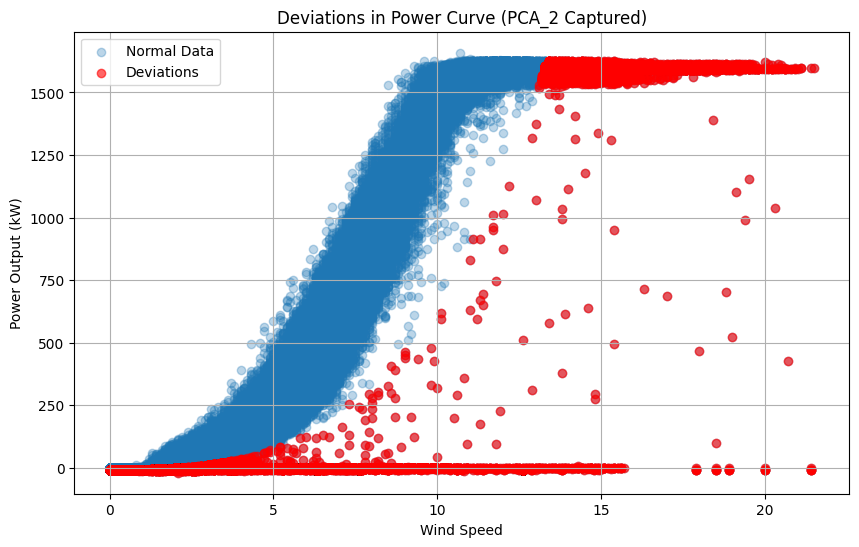

In [39]:
import matplotlib.pyplot as plt

# Plot original data vs. deviations
plt.figure(figsize=(10, 6))
plt.scatter(df_combined["WindSpeed"], df_combined["PowerkW"], alpha=0.3, label='Normal Data')
plt.scatter(df_deviations["WindSpeed"], df_deviations["PowerkW"], color='red', alpha=0.6, label='Deviations')
plt.xlabel("Wind Speed")
plt.ylabel("Power Output (kW)")
plt.title("Deviations in Power Curve (PCA_2 Captured)")
plt.legend()
plt.grid(True)
plt.show()


In [40]:
df_combined.head(2)

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed_Squared,WindSpeed_Cubic,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7
0,T01,2022-03-01,4.5,219.0,187.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,-2.831942,-3.497157,20.25,91.125,-432.827755,-64.590126,0.079951,0.507198,0.952728,0.39372,0.935129
1,T02,2022-03-01,4.9,151.0,282.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,2.375567,-4.285637,24.01,117.649,-357.128643,-1.246353,-0.089648,0.509515,0.952504,0.39377,0.934308


In [41]:
df_combined.columns

Index(['Turbine', 'StampTime', 'WindSpeed', 'WindDirection', 'PowerkW',
       'Minute', 'Hour', 'DayOfYear', 'Minute_sin', 'Minute_cos', 'Hour_sin',
       'Hour_cos', 'Day_sin', 'Day_cos', 'u_vector', 'v_vector',
       'WindSpeed_Squared', 'WindSpeed_Cubic', 'PCA_1', 'PCA_2', 'PCA_3',
       'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7'],
      dtype='object')

/tmp/ipykernel_40321/1582418212.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = subset[numeric_cols].resample(period).mean()
/tmp/ipykernel_40321/1582418212.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = subset[numeric_cols].resample(period).mean()
/tmp/ipykernel_40321/1582418212.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = subset[numeric_cols].resample(period).mean()
/tmp/ipykernel_40321/1582418212.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = subset[numeric_cols].resample(period).mean()
/tmp/ipykernel_40321/1582418212.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled = subset[numeric_cols].resample(period).mean()
/tmp/ipykernel_40321

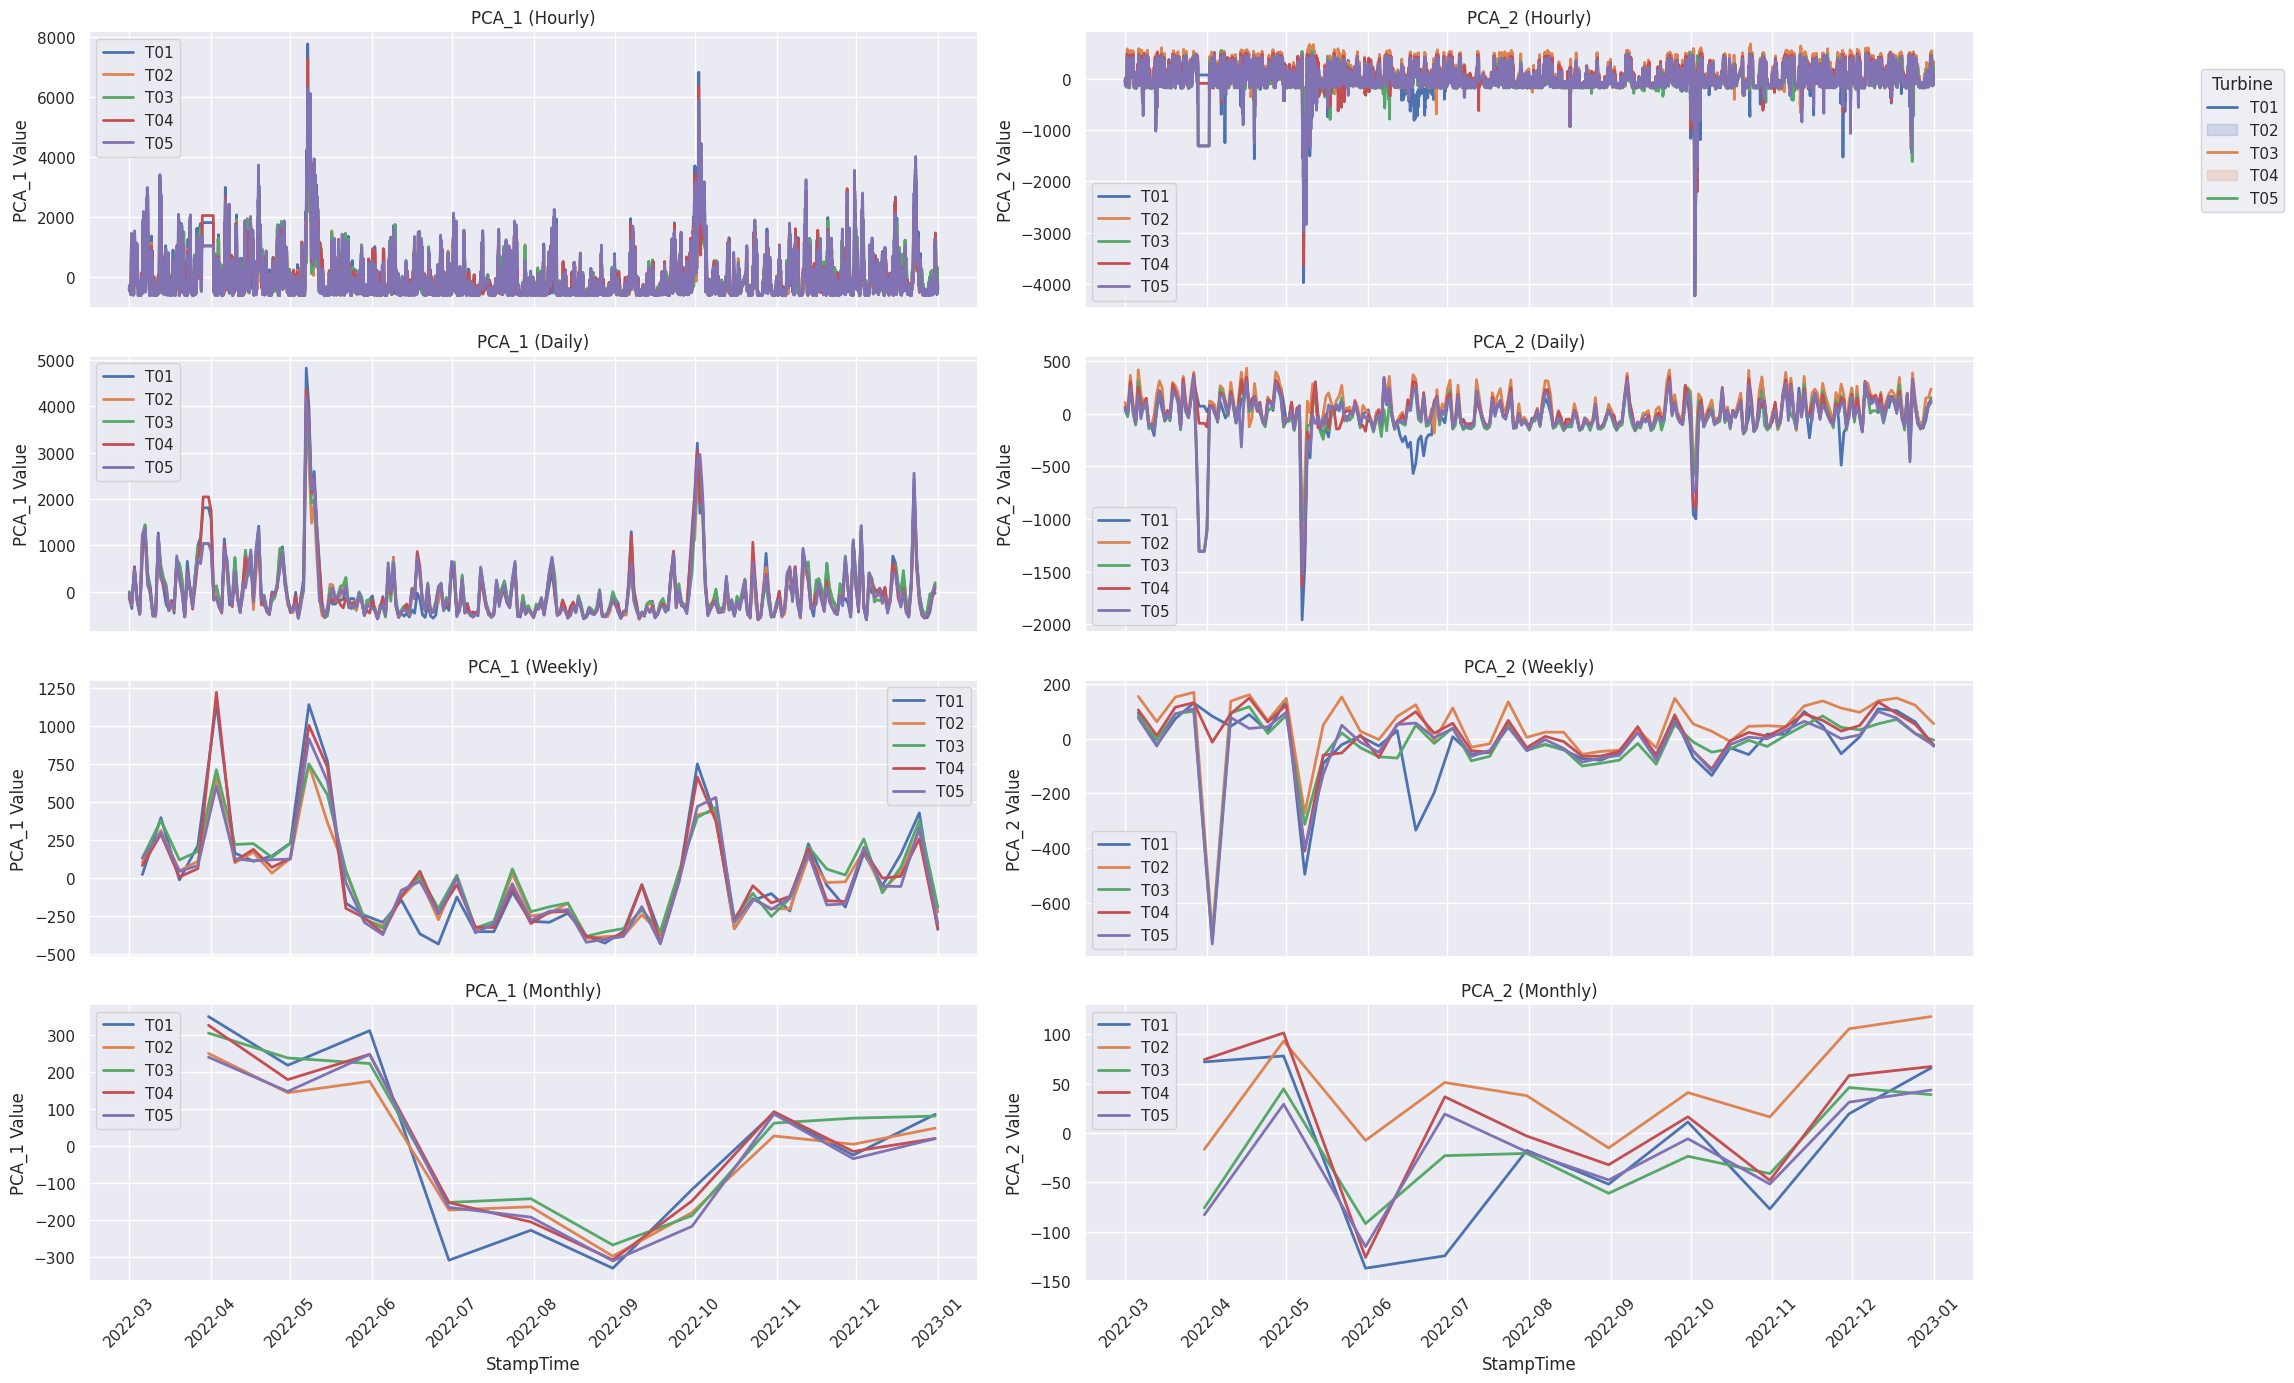

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set time as index
df_combined.set_index('StampTime', inplace=True)

# Ensure numeric columns only (PCA_1 and PCA_2)
numeric_cols = ['PCA_1', 'PCA_2']

# Define resampling periods
resample_periods = {
    'Hourly': 'H',
    'Daily': 'D',
    'Weekly': 'W',
    'Monthly': 'M'
}

# List of turbines
turbines = df_combined['Turbine'].unique()

# Precompute subsets for each turbine
turbine_data = {turbine: df_combined[df_combined['Turbine'] == turbine] for turbine in turbines}

# Set Seaborn Theme
sns.set_theme(style="darkgrid")

# Create subplots
fig, axes = plt.subplots(nrows=len(resample_periods), ncols=2, figsize=(20, 14), sharex=True)

for i, (label, period) in enumerate(resample_periods.items()):
    for turbine, subset in turbine_data.items():
        
        # Resample only numeric columns (PCA_1 and PCA_2)
        resampled = subset[numeric_cols].resample(period).mean()
        
        # Plot PCA_1
        sns.lineplot(
            ax=axes[i, 0], 
            x=resampled.index, 
            y=resampled['PCA_1'], 
            label=turbine, 
            linewidth=2
        )
        
        # Plot PCA_2
        sns.lineplot(
            ax=axes[i, 1], 
            x=resampled.index, 
            y=resampled['PCA_2'], 
            label=turbine, 
            linewidth=2
        )

    # Formatting Titles and Labels
    axes[i, 0].set_title(f"PCA_1 ({label})")
    axes[i, 0].set_ylabel("PCA_1 Value")
    
    axes[i, 1].set_title(f"PCA_2 ({label})")
    axes[i, 1].set_ylabel("PCA_2 Value")

# Apply x-tick rotation to all subplots
for ax in axes.flatten():
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    ax.grid(True)

# Improve Layout
plt.tight_layout()
fig.legend(turbines, title="Turbine", loc="upper right", bbox_to_anchor=(1.15, 0.95))
plt.show()


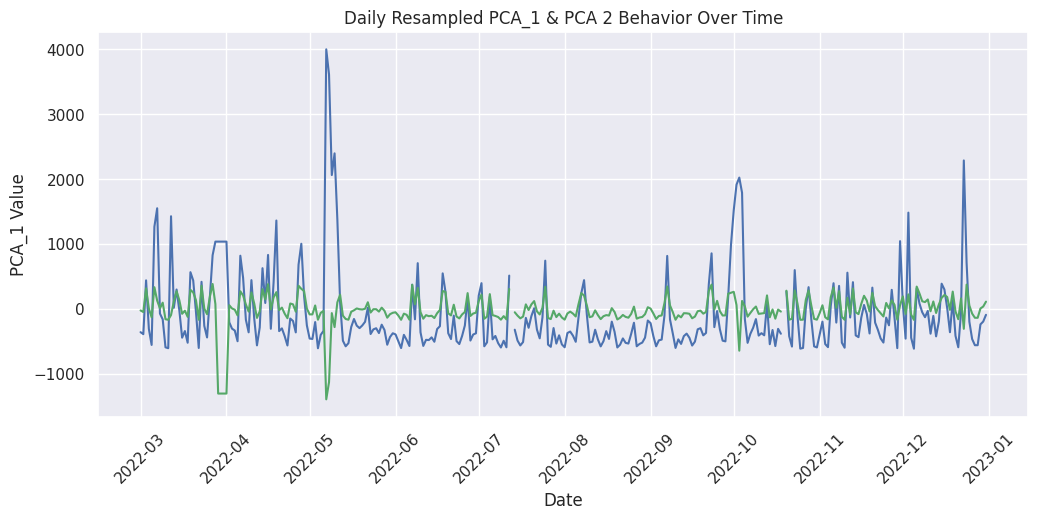

In [43]:
import matplotlib.pyplot as plt

# Ensure the StampTime column is in datetime format
# df_pca_wst['StampTime'] = pd.to_datetime(df_pca_wst['StampTime'])

# Resample PCA_1 data by day (mean value per day)
df_daily = df_combined[['PCA_1','PCA_2']].resample('D').median()

# Plot PCA_1 over time with daily resampling
plt.figure(figsize=(12, 5))
plt.plot(df_daily.index, df_daily['PCA_1'], linestyle='-', linewidth=1.5, color='b')
# plt.plot(df_daily.index, df_daily['PCA_4'], linestyle='-', linewidth=1.5, color='b')
plt.plot(df_daily.index, df_daily['PCA_2'], linestyle='-', linewidth=1.5, color='g')


plt.xlabel('Date')
plt.ylabel('PCA_1 Value')
plt.title('Daily Resampled PCA_1 & PCA 2 Behavior Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [44]:
# df_combined

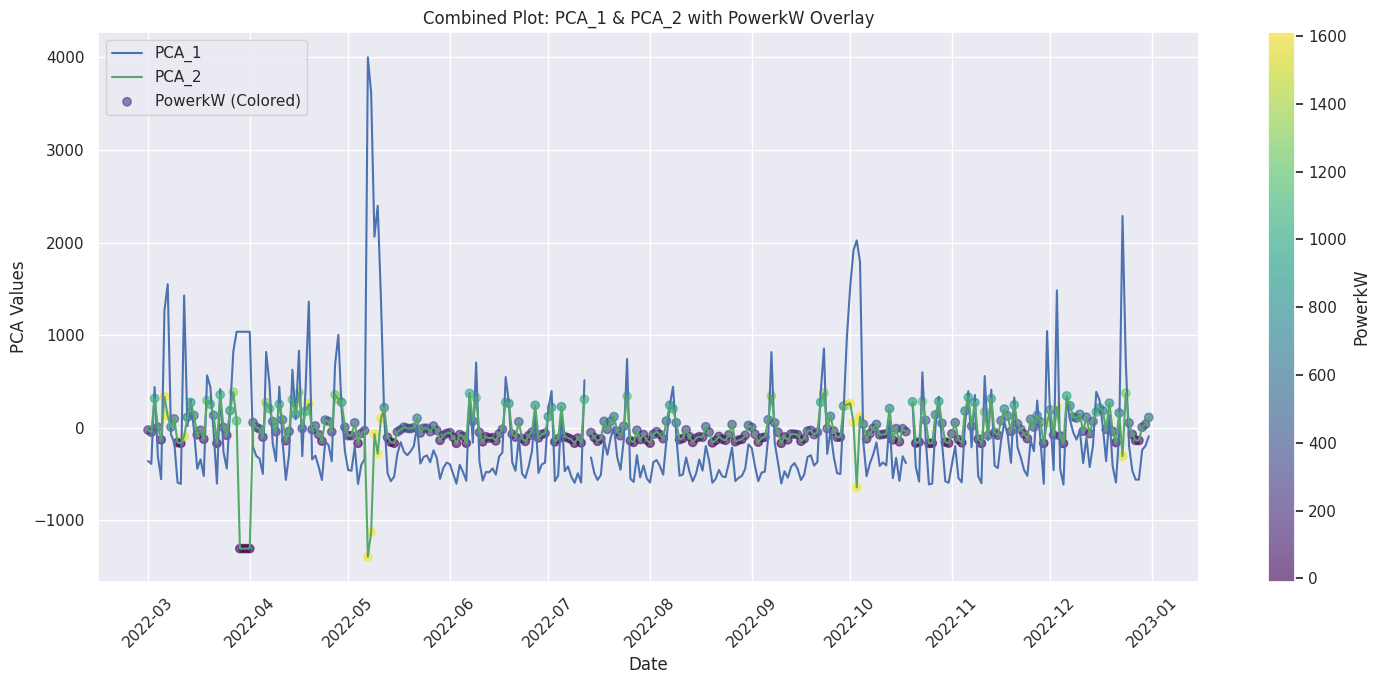

In [45]:
import matplotlib.pyplot as plt

# Resample the data for PCA_1, PCA_2, and PowerkW (Daily Median)
df_daily = df_combined[['PCA_1', 'PCA_2', 'PowerkW']].resample('D').median()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 7))

# Plot PCA_1 and PCA_2 Over Time (Line Plot)
ax.plot(df_daily.index, df_daily['PCA_1'], linestyle='-', linewidth=1.5, color='b', label='PCA_1')
ax.plot(df_daily.index, df_daily['PCA_2'], linestyle='-', linewidth=1.5, color='g', label='PCA_2')

# Plot PowerkW as Scatter Plot over the same plot
scatter = ax.scatter(
    df_daily.index, 
    df_daily['PCA_2'],  # Overlaying on PCA_2 line
    c=df_daily['PowerkW'], 
    cmap='viridis', 
    alpha=0.6,
    label='PowerkW (Colored)'
)

# Add labels, title, and legend
ax.set_xlabel('Date')
ax.set_ylabel('PCA Values')
ax.set_title('Combined Plot: PCA_1 & PCA_2 with PowerkW Overlay')
ax.legend(loc='upper left')
ax.grid(True)
ax.tick_params(axis='x', rotation=45)

# Add color bar for the scatter plot
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('PowerkW')

# Improve Layout
plt.tight_layout()
plt.show()


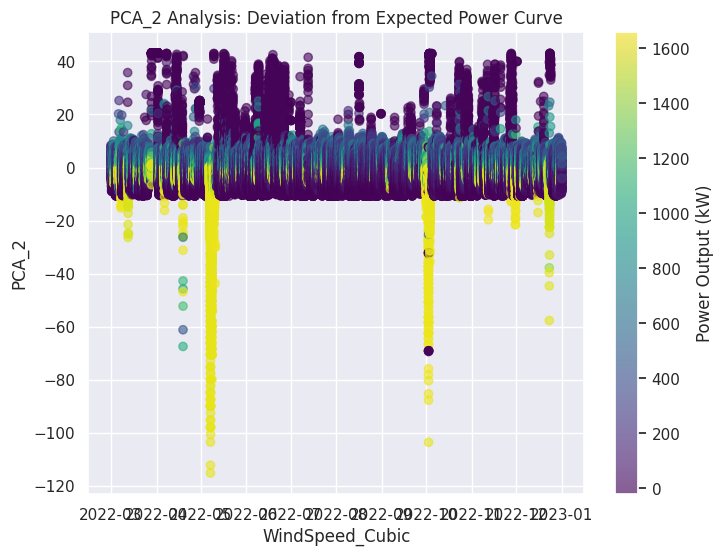

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df['StampTime'], df_pca_wst["PCA_3"], c=df["PowerkW"], cmap='viridis', alpha=0.6)
plt.colorbar(label='Power Output (kW)')
plt.xlabel('WindSpeed_Cubic')
plt.ylabel('PCA_2')
plt.title('PCA_2 Analysis: Deviation from Expected Power Curve')
plt.grid(True)
plt.show()


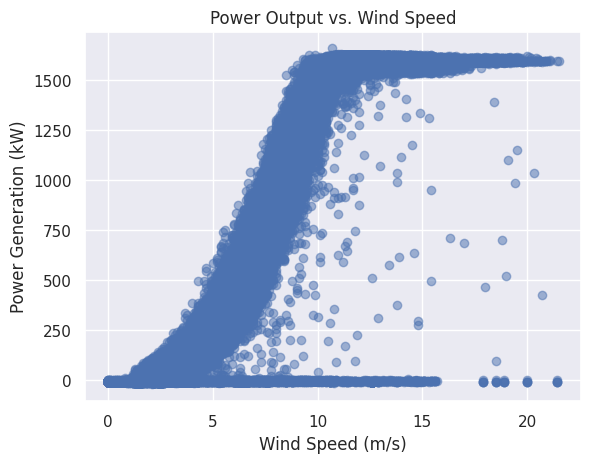

In [47]:
import matplotlib.pyplot as plt

plt.scatter(df['WindSpeed'], df['PowerkW'], alpha=0.5)
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Generation (kW)')
plt.title('Power Output vs. Wind Speed')
plt.grid(True)
plt.show()


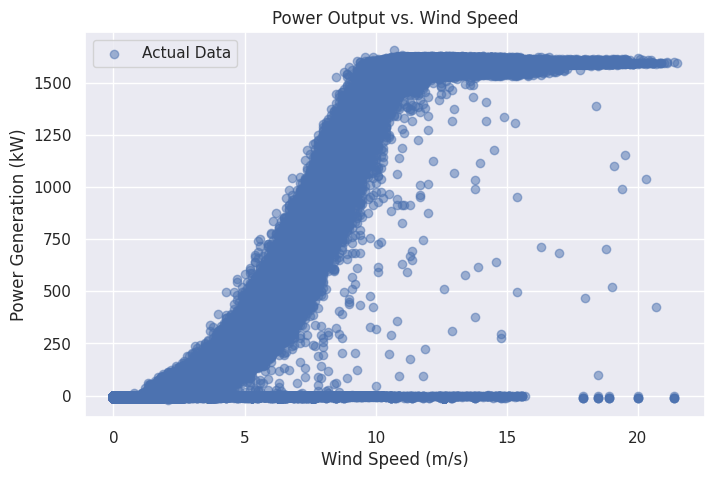

/home/noriegac/.conda/envs/cris_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


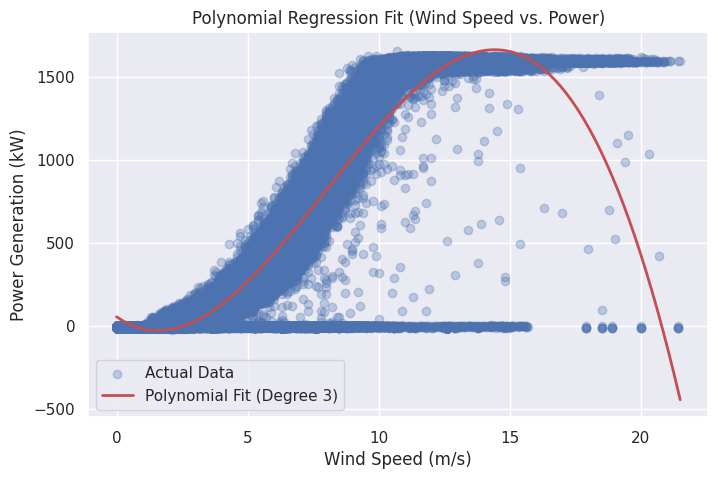

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed_Squared,WindSpeed_Cubic,WindSpeed^2,WindSpeed^3,WindSpeed*Hour
0,T01,2022-03-01,4.5,219.0,187.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,-2.831942,-3.497157,20.25,91.125,20.25,91.125,0.0
1,T02,2022-03-01,4.9,151.0,282.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,2.375567,-4.285637,24.01,117.649,24.01,117.649,0.0
2,T03,2022-03-01,6.0,276.0,319.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,-5.967131,0.627171,36.00,216.000,36.00,216.000,0.0
3,T04,2022-03-01,4.1,166.0,171.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,0.991880,-3.978212,16.81,68.921,16.81,68.921,0.0
4,T05,2022-03-01,4.8,171.0,-10.0,0,0,60,0.0,1.0,0.0,1.0,0.858764,0.512371,0.750885,-4.740904,23.04,110.592,23.04,110.592,0.0


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Scatter plot to visualize non-linearity between Wind Speed and Power Generation
plt.figure(figsize=(8, 5))
plt.scatter(df['WindSpeed'], df['PowerkW'], alpha=0.5, label='Actual Data')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Generation (kW)')
plt.title('Power Output vs. Wind Speed')
plt.grid(True)
plt.legend()
plt.show()

# Fit a Polynomial Regression Model (Degree 3 for typical wind power curves)
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(df[['WindSpeed']])
model = LinearRegression().fit(X_poly, df['PowerkW'])

# Generate predictions
wind_speed_range = np.linspace(df['WindSpeed'].min(), df['WindSpeed'].max(), 100).reshape(-1, 1)
power_predictions = model.predict(poly.transform(wind_speed_range))

# Plot polynomial regression fit
plt.figure(figsize=(8, 5))
plt.scatter(df['WindSpeed'], df['PowerkW'], alpha=0.3, label='Actual Data')
plt.plot(wind_speed_range, power_predictions, color='r', linewidth=2, label='Polynomial Fit (Degree 3)')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Generation (kW)')
plt.title('Polynomial Regression Fit (Wind Speed vs. Power)')
plt.grid(True)
plt.legend()
plt.show()

# Feature Engineering: Creating new non-linear features
df['WindSpeed^2'] = df['WindSpeed'] ** 2
df['WindSpeed^3'] = df['WindSpeed'] ** 3
df['WindSpeed*Hour'] = df['WindSpeed'] * df['Hour_sin']

# Display the first few rows with new features
df.head()


### 📊 Interpretation of PCA Components

#### 🔍 Understanding the PCA Loadings Matrix
The **PCA loadings matrix** shows how each **original feature** contributes to each **principal component (PCA_1, PCA_2, ..., PCA_7)**.

Each row represents a **principal component**, and each column represents the **original feature** (WindSpeed, PowerkW, WindSpeed_Squared, WindSpeed_Cubic, Day_sin, Day_cos, Hour_sin, Hour_cos, Minute_sin, Minute_cos).

- **High positive or negative values (close to 1 or -1):** Strong influence from that feature.  
- **Values close to 0:** That feature has little impact on that component.

---

### 🔹 Breakdown of PCA Components

#### **PCA_1 (First Component)**
- **PowerkW (0.5647)** and **WindSpeed_Cubic (0.8232)** dominate this component.  
- The strong positive loading for **PowerkW** suggests that this component is highly influenced by power generation.
- The high influence of **WindSpeed_Cubic** indicates a strong relationship between wind speed's cubic pattern and power generation.

📌 **What This Means:**  
- **PCA_1 is a "Power Generation and Wind Speed Cubic Trend" component.**  
- This component captures the overall pattern of how power generation relates to the cubic relationship of wind speed.

---

#### 🟡 **PCA_2**
- **PowerkW (0.8249)** and **WindSpeed (-0.5652)** are dominant.  
- The high positive loading for **PowerkW** and negative loading for **WindSpeed** suggest an inverse relationship between power and wind speed.

📌 **What This Means:**  
- **PCA_2 represents a "Power vs. Wind Speed Inverse Relationship".**  
- It indicates that when power output is high, wind speed tends to be lower, which could be influenced by wake effects or other environmental factors.

---

#### 🟠 **PCA_3**
- **WindSpeed_Squared (0.9875)** is the most dominant feature.  
- This suggests that this component is strongly related to the quadratic nature of wind speed.

📌 **What This Means:**  
- **PCA_3 captures "Quadratic Wind Speed Patterns".**  
- It reflects how wind speed changes over time following a squared pattern, which could be linked to efficiency losses or turbulence effects.

---

#### 🔵 **PCA_4**
- **Day_sin (0.8518)** and **Day_cos (-0.5224)** dominate this component.  
- The combination of sine and cosine components suggests a daily cyclic pattern.

📌 **What This Means:**  
- **PCA_4 represents "Daily Cycles in Wind and Power Generation".**  
- It captures how power generation and wind speed fluctuate during the day (e.g., daytime vs. nighttime trends).

---

#### 🟣 **PCA_5**
- **Minute_cos (0.9396)** and **Minute_sin (-0.3412)** dominate.  
- This component shows a periodic pattern with minute-level granularity.

📌 **What This Means:**  
- **PCA_5 reflects "Minute-scale Variability in Wind Patterns".**  
- It highlights fast, small-scale changes in wind conditions or power generation.

---

#### 🟤 **PCA_6**
- **Minute_sin (0.9387)** and **Minute_cos (0.3401)** dominate.  
- This is similar to PCA_5 but with slightly different relationships between the sine and cosine components.

📌 **What This Means:**  
- **PCA_6 represents "Another Minute-scale Wind Pattern".**  
- It may capture fluctuations not captured by PCA_5, likely related to short-term turbulence or gusts.

---

#### 🟡 **PCA_7**
- **Hour_cos (0.9903)** dominates.  
- This component shows strong periodicity at the hourly scale.

📌 **What This Means:**  
- **PCA_7 reflects "Hourly Patterns in Wind and Power Generation".**  
- This could be related to how wind changes due to thermal effects or other atmospheric conditions occurring regularly within the hour.

---

## **🔹 Summary: What Do These PCA Components Explain?**

| **PCA Component** | **Main Influencing Features** | **What It Represents** |
|------------------|----------------------------|------------------------|
| **PCA_1** | **PowerkW, WindSpeed_Cubic** | **Power Generation and Wind Speed Cubic Trend** |
| **PCA_2** | **PowerkW, WindSpeed** | **Power vs. Wind Speed Inverse Relationship** |
| **PCA_3** | **WindSpeed_Squared** | **Quadratic Wind Speed Patterns** |
| **PCA_4** | **Day_sin, Day_cos** | **Daily Cycles in Wind and Power Generation** |
| **PCA_5** | **Minute_cos, Minute_sin** | **Minute-scale Variability in Wind Patterns** |
| **PCA_6** | **Minute_sin, Minute_cos** | **Another Minute-scale Wind Pattern** |
| **PCA_7** | **Hour_cos** | **Hourly Patterns in Wind and Power Generation** |

---



In [49]:
df[df.isna().any(axis=1)]

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed_Squared,WindSpeed_Cubic,WindSpeed^2,WindSpeed^3,WindSpeed*Hour


In [50]:
# Group by timestamp and compute standard deviation for u, v, and power output
df_std = df.groupby("StampTime").agg({
    "u_vector": "std",
    "v_vector": "std",
    "PowerkW": "std"
}).reset_index()

# Rename columns for clarity
df_std.rename(columns={
    "u_vector": "u_std",
    "v_vector": "v_std",
    "PowerkW": "power_std"
}, inplace=True)

In [51]:
df_std

,StampTime,u_std,v_std,power_std
0,2022-03-01 00:00:00,3.407186,2.173189,127.940220
1,2022-03-01 00:10:00,3.348069,2.310839,133.421513
2,2022-03-01 00:20:00,3.408682,2.798757,104.915680
3,2022-03-01 00:30:00,3.336925,3.413684,43.246965
4,2022-03-01 00:40:00,3.364933,3.436971,54.869846
...,...,...,...,...
43296,2022-12-31 23:10:00,2.232191,2.071392,17.991665
43297,2022-12-31 23:20:00,2.028500,1.880311,11.781341
43298,2022-12-31 23:30:00,3.515498,3.606940,34.992856
43299,2022-12-31 23:40:00,3.680658,3.980729,94.592283


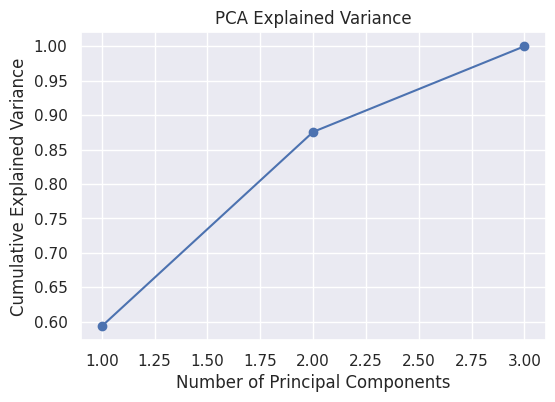

In [52]:
# Select numerical columns for PCA (exclude timestamp)
features = df_std[['u_std', 'v_std', 'power_std']]  # Adjust if necessary

# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA
pca = PCA()
pca_transformed = pca.fit_transform(features_scaled)

# Explained variance plot to determine the number of components to keep
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

## Analyzing variability by turbine wind patterns and energy output

In [53]:
df['u_vector_cubic'] = np.sin(np.radians(df['WindDirection'])) * df['WindSpeed_Cubic']
df['v_vector_cubic'] = np.cos(np.radians(df['WindDirection'])) * df['WindSpeed_Cubic']

In [54]:
# Convert StampTime to datetime
df["StampTime"] = pd.to_datetime(df["StampTime"])

# Pivot dataset to represent wind conditions at each timestamp
df_pivot = df.pivot(index="StampTime", columns="Turbine", values=["u_vector_cubic", "v_vector_cubic", "PowerkW"])

# Flatten multi-index columns
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
df_pivot.reset_index(inplace=True)

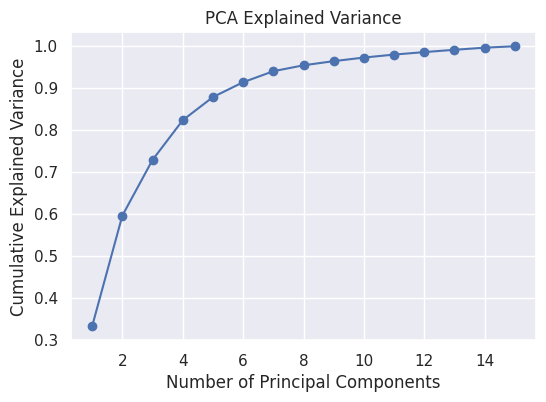

In [55]:
# Standardize the features before PCA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_pivot.iloc[:,1:])

# Apply PCA
pca = PCA()
pca_transformed = pca.fit_transform(features_scaled)

# Explained variance plot to determine the number of components to keep
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

In [56]:
# Determine optimal number of components (e.g., keep enough to explain ~95% variance)
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of PCA components: {n_components}")

Optimal number of PCA components: 8


In [57]:
# Apply PCA with optimal components
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(features_scaled)

In [58]:
# Convert PCA results to DataFrame
pca_columns = [f"PCA_{i+1}" for i in range(n_components)]
df_pca = pd.DataFrame(pca_features, columns=pca_columns)

In [59]:
df_pivot

,StampTime,u_vector_cubic_T01,u_vector_cubic_T02,u_vector_cubic_T03,u_vector_cubic_T04,u_vector_cubic_T05,v_vector_cubic_T01,v_vector_cubic_T02,v_vector_cubic_T03,v_vector_cubic_T04,v_vector_cubic_T05,PowerkW_T01,PowerkW_T02,PowerkW_T03,PowerkW_T04,PowerkW_T05
0,2022-03-01 00:00:00,-57.346821,57.037367,-214.816729,16.673499,17.300400,-70.817426,-102.898134,22.578148,-66.873752,-109.230429,187.0,282.0,319.0,171.0,-10.0
1,2022-03-01 00:10:00,-43.547834,61.638490,-193.213183,19.777088,30.240237,-59.938451,-126.377633,27.154342,-60.867617,-121.286966,149.0,332.0,284.0,163.0,-10.0
2,2022-03-01 00:20:00,-119.769824,45.513008,-163.847390,8.483391,-139.559929,-128.437412,-93.315494,28.890716,-96.965607,17.135805,355.0,259.0,234.0,225.0,64.0
3,2022-03-01 00:30:00,-85.266419,56.060735,-174.947728,17.923509,-98.501344,-101.616561,-120.222634,15.305943,-71.887270,76.957684,272.0,313.0,258.0,193.0,252.0
4,2022-03-01 00:40:00,-66.736138,59.423509,-182.912967,18.997202,-98.501344,-79.533032,-127.434125,28.970568,-66.251117,76.957684,230.0,329.0,276.0,181.0,260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43296,2022-12-31 23:10:00,21.276290,-10.307237,-48.449100,-6.315987,3.532646,16.622860,22.103941,-25.760844,6.773067,-5.879311,55.0,52.0,57.0,27.0,18.0
43297,2022-12-31 23:20:00,13.850077,-9.240609,-34.038262,-3.826136,4.408880,10.820866,17.379057,-19.652000,4.401466,-5.254299,38.0,42.0,33.0,18.0,16.0
43298,2022-12-31 23:30:00,73.473157,-63.300744,-95.894425,-29.437867,75.644279,101.127124,65.549839,-102.834181,20.612616,-61.255530,195.0,179.0,152.0,107.0,182.0
43299,2022-12-31 23:40:00,79.727996,-93.958669,-117.421333,-3.547240,117.923791,156.475002,70.802936,-155.823372,2.048000,-76.580605,274.0,231.0,204.0,33.0,239.0


In [60]:
df_pivot.iloc[:,1:].columns

Index(['u_vector_cubic_T01', 'u_vector_cubic_T02', 'u_vector_cubic_T03',
       'u_vector_cubic_T04', 'u_vector_cubic_T05', 'v_vector_cubic_T01',
       'v_vector_cubic_T02', 'v_vector_cubic_T03', 'v_vector_cubic_T04',
       'v_vector_cubic_T05', 'PowerkW_T01', 'PowerkW_T02', 'PowerkW_T03',
       'PowerkW_T04', 'PowerkW_T05'],
      dtype='object')

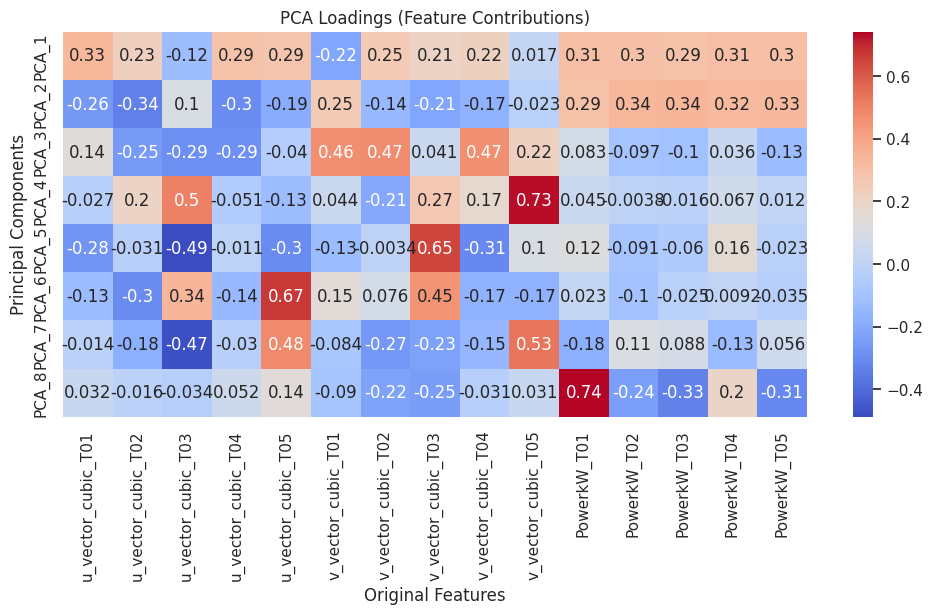

In [61]:
# Visualize PCA Component Contribution (Loadings)
plt.figure(figsize=(12, 5))
sns.heatmap(pca.components_, cmap="coolwarm", annot=True, xticklabels=df_pivot.iloc[:,1:].columns, yticklabels=pca_columns)
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.title("PCA Loadings (Feature Contributions)")
plt.show()

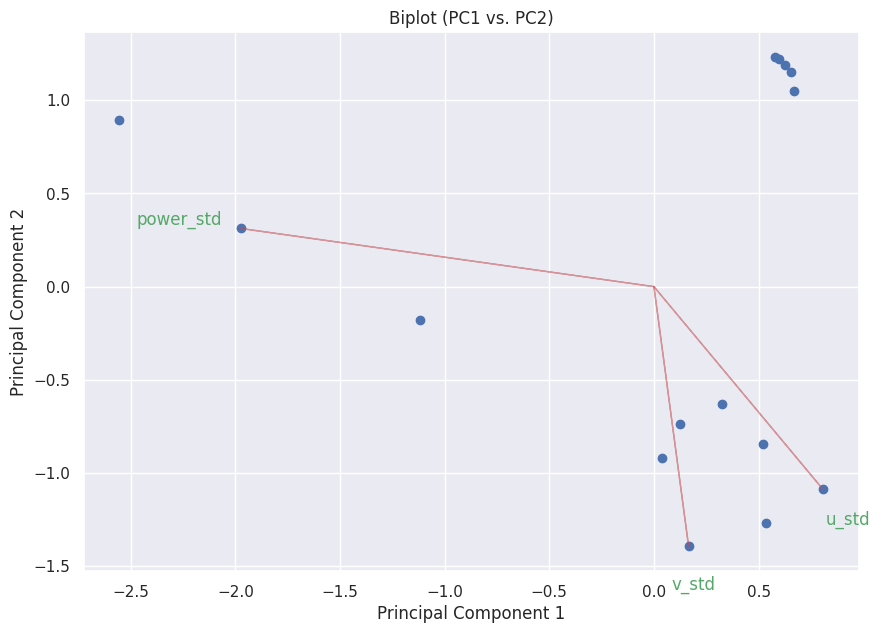

In [62]:
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
scaled_pca_components = scaler.fit_transform(pca.components_.T)

# Plotting the biplot
plt.figure(figsize=(10, 7))
plt.scatter(scaled_pca_components[:, 0], scaled_pca_components[:, 1])

# Adding labels to the plot
for i, feature in enumerate(features):
    plt.arrow(0, 0, scaled_pca_components[i, 0], scaled_pca_components[i, 1], 
              color='r', alpha=0.5)
    plt.text(scaled_pca_components[i, 0] * 1.15, scaled_pca_components[i, 1] * 1.15, 
             feature, color='g', ha='center', va='center')

plt.title('Biplot (PC1 vs. PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


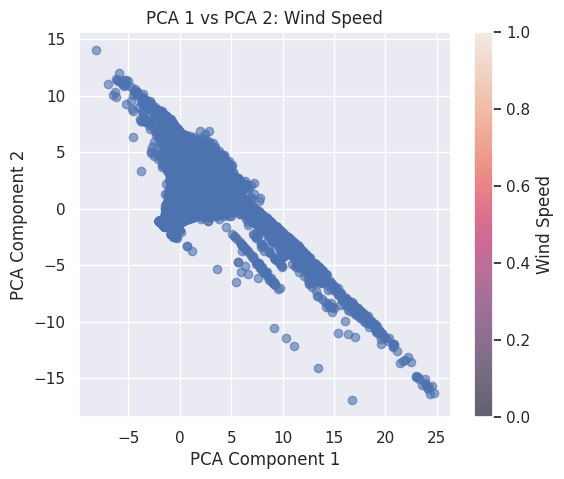

In [63]:
# Visualize the first two PCA components
plt.figure(figsize=(6, 5))
plt.scatter(df_pca["PCA_1"], df_pca["PCA_2"], alpha=0.6)
plt.colorbar(label='Wind Speed')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA 1 vs PCA 2: Wind Speed")
plt.grid(True)
plt.show()

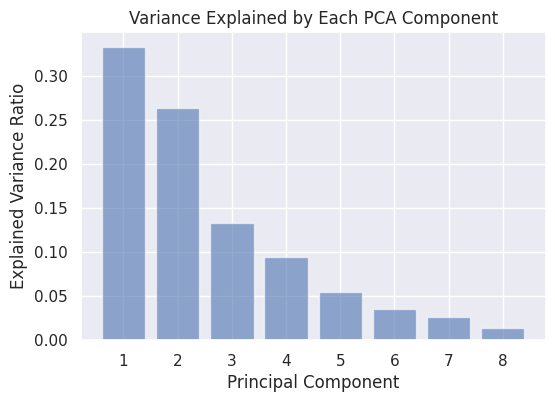

In [64]:
# Plot explained variance of each PCA component
plt.figure(figsize=(6, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.6)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Each PCA Component")
plt.grid(True)
plt.show()


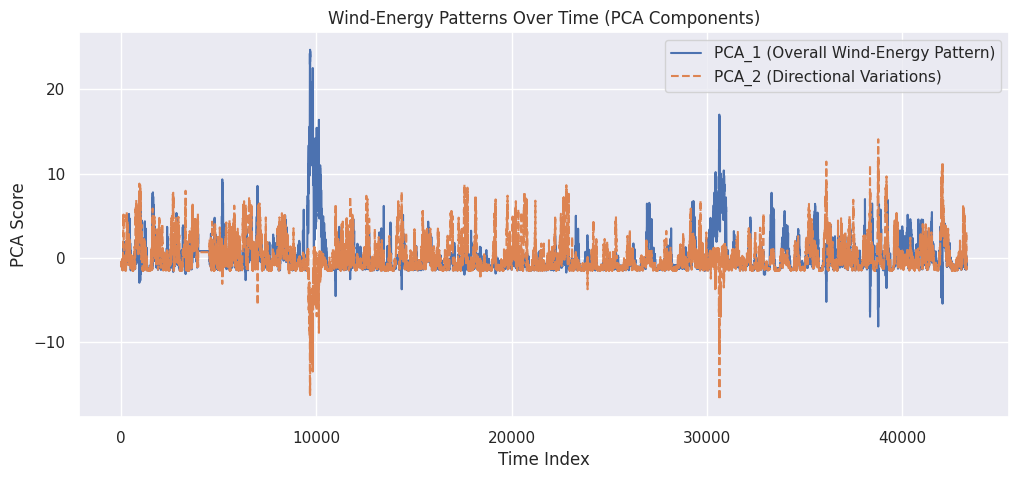

In [65]:
plt.figure(figsize=(12, 5))
plt.plot(df_pca.index, df_pca["PCA_1"], label="PCA_1 (Overall Wind-Energy Pattern)", linestyle="-")
plt.plot(df_pca.index, df_pca["PCA_2"], label="PCA_2 (Directional Variations)", linestyle="--")
plt.xlabel("Time Index")
plt.ylabel("PCA Score")
plt.title("Wind-Energy Patterns Over Time (PCA Components)")
plt.legend()
plt.grid(True)
plt.show()


In [66]:
df_pivot

,StampTime,u_vector_cubic_T01,u_vector_cubic_T02,u_vector_cubic_T03,u_vector_cubic_T04,u_vector_cubic_T05,v_vector_cubic_T01,v_vector_cubic_T02,v_vector_cubic_T03,v_vector_cubic_T04,v_vector_cubic_T05,PowerkW_T01,PowerkW_T02,PowerkW_T03,PowerkW_T04,PowerkW_T05
0,2022-03-01 00:00:00,-57.346821,57.037367,-214.816729,16.673499,17.300400,-70.817426,-102.898134,22.578148,-66.873752,-109.230429,187.0,282.0,319.0,171.0,-10.0
1,2022-03-01 00:10:00,-43.547834,61.638490,-193.213183,19.777088,30.240237,-59.938451,-126.377633,27.154342,-60.867617,-121.286966,149.0,332.0,284.0,163.0,-10.0
2,2022-03-01 00:20:00,-119.769824,45.513008,-163.847390,8.483391,-139.559929,-128.437412,-93.315494,28.890716,-96.965607,17.135805,355.0,259.0,234.0,225.0,64.0
3,2022-03-01 00:30:00,-85.266419,56.060735,-174.947728,17.923509,-98.501344,-101.616561,-120.222634,15.305943,-71.887270,76.957684,272.0,313.0,258.0,193.0,252.0
4,2022-03-01 00:40:00,-66.736138,59.423509,-182.912967,18.997202,-98.501344,-79.533032,-127.434125,28.970568,-66.251117,76.957684,230.0,329.0,276.0,181.0,260.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43296,2022-12-31 23:10:00,21.276290,-10.307237,-48.449100,-6.315987,3.532646,16.622860,22.103941,-25.760844,6.773067,-5.879311,55.0,52.0,57.0,27.0,18.0
43297,2022-12-31 23:20:00,13.850077,-9.240609,-34.038262,-3.826136,4.408880,10.820866,17.379057,-19.652000,4.401466,-5.254299,38.0,42.0,33.0,18.0,16.0
43298,2022-12-31 23:30:00,73.473157,-63.300744,-95.894425,-29.437867,75.644279,101.127124,65.549839,-102.834181,20.612616,-61.255530,195.0,179.0,152.0,107.0,182.0
43299,2022-12-31 23:40:00,79.727996,-93.958669,-117.421333,-3.547240,117.923791,156.475002,70.802936,-155.823372,2.048000,-76.580605,274.0,231.0,204.0,33.0,239.0


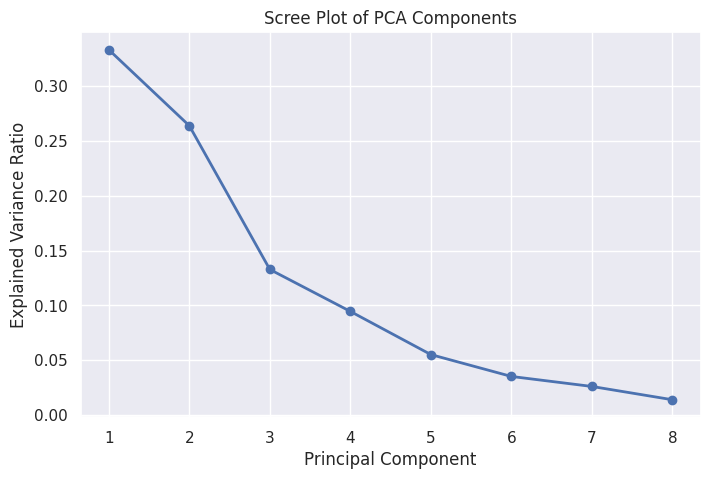

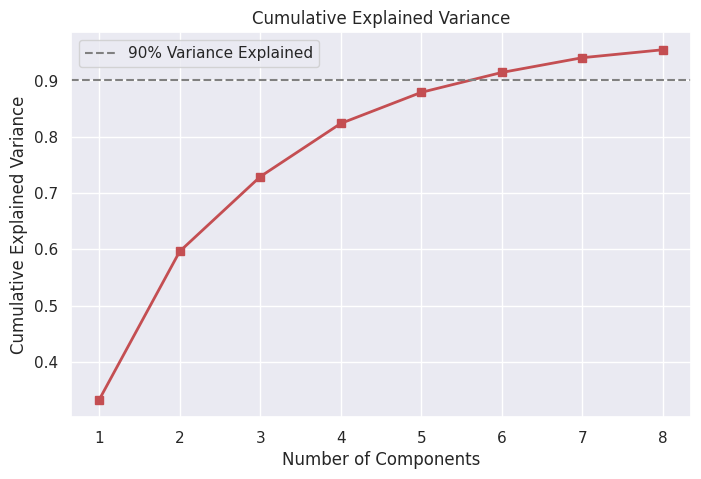

In [67]:
# PCA explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Number of components
num_components = np.arange(1, len(explained_variance_ratio) + 1)

# Scree Plot (Explained Variance per Component)
plt.figure(figsize=(8, 5))
plt.plot(num_components, explained_variance_ratio, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot of PCA Components')
plt.grid(True)
plt.show()

# Cumulative Variance Explained Plot
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(num_components, cumulative_variance, marker='s', linestyle='-', linewidth=2, color='r')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.axhline(y=0.9, color='gray', linestyle='--', label='90% Variance Explained')
plt.grid(True)
plt.legend()
plt.show()

# Calculating azimuths (turbines as the poligonal)

In [68]:
import math
import pandas as pd

# Define turbine locations
turbine_locations = {
    "T01": {"latitude": 39.3839, "longitude": -74.4485},
    "T02": {"latitude": 39.3822, "longitude": -74.4504},
    "T03": {"latitude": 39.3801, "longitude": -74.4497},
    "T04": {"latitude": 39.3825, "longitude": -74.4454},
    "T05": {"latitude": 39.3811, "longitude": -74.4477}
}

# Function to calculate azimuth between two points
def calculate_azimuth(coord1, coord2):
    lat1, lon1 = math.radians(coord1[0]), math.radians(coord1[1])
    lat2, lon2 = math.radians(coord2[0]), math.radians(coord2[1])
    
    d_lon = lon2 - lon1

    x = math.sin(d_lon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1) * math.cos(lat2) * math.cos(d_lon))

    initial_bearing = math.atan2(x, y)
    initial_bearing = math.degrees(initial_bearing)
    
    # Normalize to 0 - 360 degrees
    compass_bearing = (initial_bearing + 360) % 360
    return compass_bearing

# Prepare results
results = []

# Calculate azimuths between all turbines
turbine_names = list(turbine_locations.keys())
for turbine1 in turbine_names:
    for turbine2 in turbine_names:
        if turbine1 != turbine2:
            coord1 = (turbine_locations[turbine1]["latitude"], turbine_locations[turbine1]["longitude"])
            coord2 = (turbine_locations[turbine2]["latitude"], turbine_locations[turbine2]["longitude"])
            
            azimuth = calculate_azimuth(coord1, coord2)
            results.append([turbine1, turbine2, azimuth])

# Convert results to DataFrame
df_azimuths = pd.DataFrame(results, columns=["From Turbine", "To Turbine", "Azimuth (Degrees)"])

# Display the results
print(df_azimuths)


   From Turbine To Turbine  Azimuth (Degrees)
0           T01        T02         220.822803
1           T01        T03         193.717165
2           T01        T04         120.296537
3           T01        T05         167.546626
4           T02        T01          40.821598
5           T02        T03         165.551890
6           T02        T04          85.559628
7           T02        T05         117.792418
8           T03        T01          13.716403
9           T03        T02         345.552334
10          T03        T04          54.165631
11          T03        T05          57.101601
12          T04        T01         300.298504
13          T04        T02         265.562801
14          T04        T03         234.168360
15          T04        T05         231.779876
16          T05        T01         347.547133
17          T05        T02         297.794131
18          T05        T03         237.102870
19          T05        T04          51.778417


In [69]:
# Define the order of the polygonal
polygonal_order = ["T02", "T01", "T04", "T05", "T03", "T02", "T01"]

# Prepare results for external angles
external_angles = []

# Loop over the polygonal order to calculate external angles
for i in range(1, len(polygonal_order) - 1):
    current_turbine = polygonal_order[i]
    previous_turbine = polygonal_order[i - 1]
    next_turbine = polygonal_order[i + 1]
    
    # Coordinates of the turbines
    coord_current = (turbine_locations[current_turbine]["latitude"], turbine_locations[current_turbine]["longitude"])
    coord_previous = (turbine_locations[previous_turbine]["latitude"], turbine_locations[previous_turbine]["longitude"])
    coord_next = (turbine_locations[next_turbine]["latitude"], turbine_locations[next_turbine]["longitude"])
    
    # Calculate azimuths
    azimuth_to_previous = calculate_azimuth(coord_current, coord_previous)
    azimuth_to_next = calculate_azimuth(coord_current, coord_next)
    
    # Calculate external angle
    external_angle_start = azimuth_to_previous
    external_angle_end = azimuth_to_next
    external_angle_span = (external_angle_end - external_angle_start) % 360  # Ensure it's within [0, 360]
    
    # Save the results
    external_angles.append({
        "Turbine": current_turbine,
        "Azimuth to Previous": azimuth_to_previous,
        "Azimuth to Next": azimuth_to_next,
        "External Angle Start": external_angle_start,
        "External Angle End": external_angle_end,
        "External Angle Span": external_angle_span
    })

# Convert results to DataFrame
df_external_angles = pd.DataFrame(external_angles)

# Display the results to the user
# tools.display_dataframe_to_user(name="External Angles for Each Turbine", dataframe=df_external_angles)


In [70]:
df_external_angles

,Turbine,Azimuth to Previous,Azimuth to Next,External Angle Start,External Angle End,External Angle Span
0,T01,220.822803,120.296537,220.822803,120.296537,259.473734
1,T04,300.298504,231.779876,300.298504,231.779876,291.481372
2,T05,51.778417,237.102870,51.778417,237.102870,185.324453
3,T03,57.101601,345.552334,57.101601,345.552334,288.450733
4,T02,165.551890,40.821598,165.551890,40.821598,235.269707


In [71]:
df.iloc[:10,-5:]

,WindSpeed^2,WindSpeed^3,WindSpeed*Hour,u_vector_cubic,v_vector_cubic
0,20.25,91.125,0.0,-57.346821,-70.817426
1,24.01,117.649,0.0,57.037367,-102.898134
2,36.00,216.000,0.0,-214.816729,22.578148
3,16.81,68.921,0.0,16.673499,-66.873752
4,23.04,110.592,0.0,17.300400,-109.230429
5,17.64,74.088,0.0,-43.547834,-59.938451
6,27.04,140.608,0.0,61.638490,-126.377633
7,33.64,195.112,0.0,-193.213183,27.154342
8,16.00,64.000,0.0,19.777088,-60.867617
9,25.00,125.000,0.0,30.240237,-121.286966


In [72]:
import pandas as pd

def analyze_wind_impact(df_data, df_external_angles):
    """
    Analyze how wind blowing from the external angles affects other turbines.

    Args:
    - df_data: DataFrame containing wind data for all turbines (with 'Turbine', 'StampTime', 'WindDirection', 'PowerkW')
    - df_external_angles: DataFrame with external angles for each turbine

    Returns:
    - DataFrame showing turbines affected by wind blowing from external angles
    """
    wind_impact_results = []

    # Loop over each row in the data
    for index, row in df_data.iterrows():
        current_turbine = row["Turbine"]
        current_wind_direction = row["WindDirection"]
        timestamp = row["StampTime"]
        
        # Find the external angle data for the current turbine
        external_angle_data = df_external_angles[df_external_angles["Turbine"] == current_turbine]

        if not external_angle_data.empty:
            external_start = external_angle_data["External Angle Start"].values[0]
            external_end = external_angle_data["External Angle End"].values[0]
            
            # Check if the wind direction is within the external angle range
            if external_start < external_end:
                is_within_range = (external_start <= current_wind_direction <= external_end)
            else:
                is_within_range = (current_wind_direction >= external_start or current_wind_direction <= external_end)
            
            if is_within_range:
                # If the wind is blowing from the external angle range, check how it affects other turbines
                for turbine_name in df_data['Turbine'].unique():
                    if turbine_name != current_turbine:
                        # Find the data for the affected turbine at the same timestamp
                        affected_row = df_data[(df_data["Turbine"] == turbine_name) & (df_data["StampTime"] == timestamp)]

                        if not affected_row.empty:
                            affected_power = affected_row["PowerkW"].values[0]
                            wind_impact_results.append({
                                "Timestamp": timestamp,
                                "Blowing Turbine": current_turbine,
                                "Affected Turbine": turbine_name,
                                "Wind Direction": current_wind_direction,
                                "Affected Power (kW)": affected_power
                            })

    # Convert results to DataFrame
    df_wind_impact = pd.DataFrame(wind_impact_results)
    return df_wind_impact


In [73]:
df_wind_impact = analyze_wind_impact(df, df_external_angles)

In [74]:
df

,Turbine,StampTime,WindSpeed,WindDirection,PowerkW,Minute,Hour,DayOfYear,Minute_sin,Minute_cos,Hour_sin,Hour_cos,Day_sin,Day_cos,u_vector,v_vector,WindSpeed_Squared,WindSpeed_Cubic,WindSpeed^2,WindSpeed^3,WindSpeed*Hour,u_vector_cubic,v_vector_cubic
0,T01,2022-03-01 00:00:00,4.5,219.0,187.0,0,0,60,0.000000,1.0,0.000000,1.000000,8.587640e-01,0.512371,-2.831942,-3.497157,20.25,91.125,20.25,91.125,0.000000,-57.346821,-70.817426
1,T02,2022-03-01 00:00:00,4.9,151.0,282.0,0,0,60,0.000000,1.0,0.000000,1.000000,8.587640e-01,0.512371,2.375567,-4.285637,24.01,117.649,24.01,117.649,0.000000,57.037367,-102.898134
2,T03,2022-03-01 00:00:00,6.0,276.0,319.0,0,0,60,0.000000,1.0,0.000000,1.000000,8.587640e-01,0.512371,-5.967131,0.627171,36.00,216.000,36.00,216.000,0.000000,-214.816729,22.578148
3,T04,2022-03-01 00:00:00,4.1,166.0,171.0,0,0,60,0.000000,1.0,0.000000,1.000000,8.587640e-01,0.512371,0.991880,-3.978212,16.81,68.921,16.81,68.921,0.000000,16.673499,-66.873752
4,T05,2022-03-01 00:00:00,4.8,171.0,-10.0,0,0,60,0.000000,1.0,0.000000,1.000000,8.587640e-01,0.512371,0.750885,-4.740904,23.04,110.592,23.04,110.592,0.000000,17.300400,-109.230429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216500,T01,2022-12-31 23:50:00,6.3,19.0,430.0,50,23,365,-0.866025,0.5,-0.258819,0.965926,6.432491e-16,1.000000,2.051079,5.956767,39.69,250.047,39.69,250.047,-1.630560,81.407340,236.424083
216501,T02,2022-12-31 23:50:00,5.7,301.0,406.0,50,23,365,-0.866025,0.5,-0.258819,0.965926,6.432491e-16,1.000000,-4.885854,2.935717,32.49,185.193,32.49,185.193,-1.475269,-158.741384,95.381446
216502,T03,2022-12-31 23:50:00,6.5,209.0,375.0,50,23,365,-0.866025,0.5,-0.258819,0.965926,6.432491e-16,1.000000,-3.151263,-5.685028,42.25,274.625,42.25,274.625,-1.682324,-133.140842,-240.192437
216503,T04,2022-12-31 23:50:00,3.9,287.0,212.0,50,23,365,-0.866025,0.5,-0.258819,0.965926,6.432491e-16,1.000000,-3.729589,1.140250,15.21,59.319,15.21,59.319,-1.009394,-56.727042,17.343197


In [75]:
df_wind_impact.head(20)

,Timestamp,Blowing Turbine,Affected Turbine,Wind Direction,Affected Power (kW)
0,2022-03-01 00:00:00,T03,T01,276.0,187.0
1,2022-03-01 00:00:00,T03,T02,276.0,282.0
2,2022-03-01 00:00:00,T03,T04,276.0,171.0
3,2022-03-01 00:00:00,T03,T05,276.0,-10.0
4,2022-03-01 00:00:00,T04,T01,166.0,187.0
5,2022-03-01 00:00:00,T04,T02,166.0,282.0
6,2022-03-01 00:00:00,T04,T03,166.0,319.0
7,2022-03-01 00:00:00,T04,T05,166.0,-10.0
8,2022-03-01 00:00:00,T05,T01,171.0,187.0
9,2022-03-01 00:00:00,T05,T02,171.0,282.0
